# Graph Contrastive Learning for Nuclei Coordinate Prediction

This notebook demonstrates how we can apply contrastive learning techniques to improve our graph neural network's ability to predict nuclei coordinates in syncytial tissue. Graph contrastive learning helps the model learn more robust representations by creating multiple augmented views of the graph data.

In [1]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Add the current directory to path for importing local modules
sys.path.append(os.getcwd())

from data_utils import load_data, build_graph, create_coordinate_prediction_data
from contrastive_gcn import ContrastiveGCN
from contrastive_utils import train_contrastive_model, evaluate_contrastive_model, create_graph_views

## 1. Load and prepare data

First, let's load our nuclei coordinates and build a Delaunay triangulation graph.

In [2]:
# Load coordinates
print("Loading nuclei coordinates...")
coordinates = load_data()
print(f"Loaded {len(coordinates)} nuclei")

# Build graph
print("Building Delaunay graph...")
G, _ = build_graph(coordinates)
print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Create coordinate prediction data
print("Creating coordinate prediction task...")
data = create_coordinate_prediction_data(coordinates, G, missing_fraction=0.25)

print("=== Coordinate Prediction Task ===")
print(f"Total nodes: {data.x.shape[0]}")
print(f"Visible nodes: {data.visible_mask.sum().item()}")
print(f"Hidden nodes: {data.hidden_mask.sum().item()}")
print(f"Edges: {data.edge_index.shape[1]}")
print(f"Node features: {data.x.shape[1]} dimensions")

Loading nuclei coordinates...
Loaded 3340 nuclei
Building Delaunay graph...
Graph: 3340 nodes, 9992 edges
Creating coordinate prediction task...
Hiding 1092 nodes (32.7%) in 5 clusters
Keeping 2248 nodes visible for training
=== Coordinate Prediction Task ===
Total nodes: 3340
Visible nodes: 2248
Hidden nodes: 1092
Edges: 19984
Node features: 6 dimensions


## 2. Visualize the graph augmentations

Graph contrastive learning relies on creating different "views" of the same graph through augmentations. Let's visualize what these augmentations look like.

/Users/dev/Library/Python/3.9/lib/python/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


Original graph: 9992 edges
View 1: 7061 edges (2931 dropped)
View 2: 7009 edges (2983 dropped)


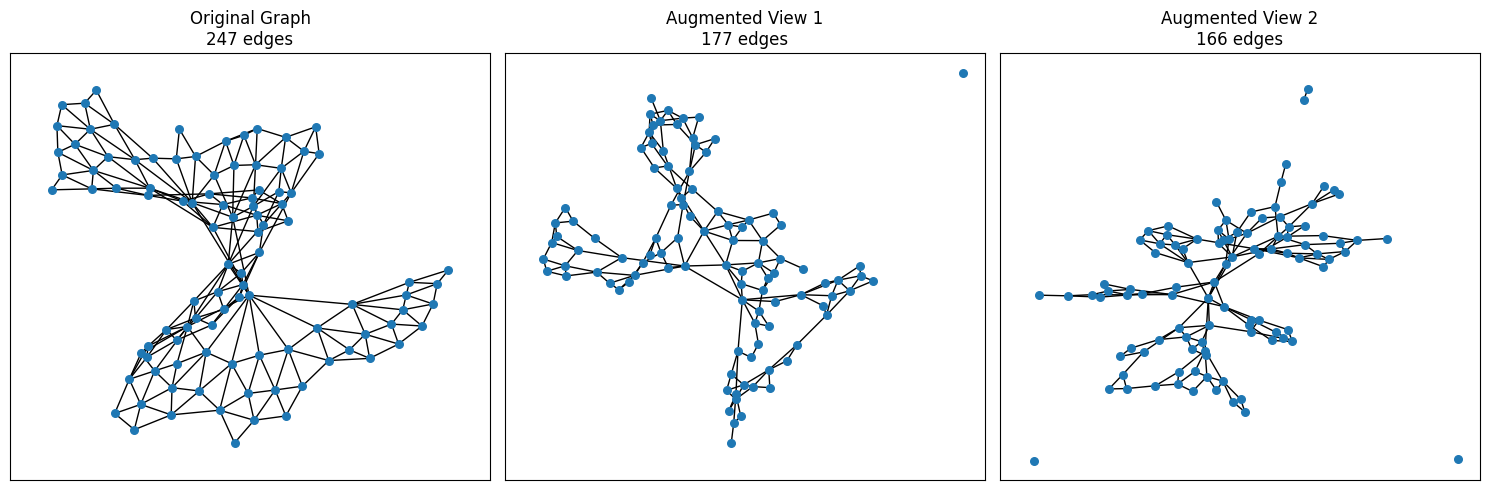

In [3]:
def visualize_graph_views(data, edge_dropout=0.3, feature_mask=0.3):
    """Visualize different augmented views of the graph"""
    # Create two augmented views
    view1, view2 = create_graph_views(data, edge_dropout_prob=edge_dropout, feature_mask_prob=feature_mask)
    
    # Convert to NetworkX for visualization
    G_original = to_networkx(data, to_undirected=True)
    G_view1 = to_networkx(view1, to_undirected=True)
    G_view2 = to_networkx(view2, to_undirected=True)
    
    # Calculate edge differences
    original_edges = set(G_original.edges())
    view1_edges = set(G_view1.edges())
    view2_edges = set(G_view2.edges())
    
    dropped_edges1 = original_edges - view1_edges
    dropped_edges2 = original_edges - view2_edges
    
    # Count differences
    print(f"Original graph: {len(original_edges)} edges")
    print(f"View 1: {len(view1_edges)} edges ({len(dropped_edges1)} dropped)")
    print(f"View 2: {len(view2_edges)} edges ({len(dropped_edges2)} dropped)")
    
    # Extract a small subgraph for visualization (100 nodes)
    nodes_to_vis = list(range(100))
    
    sub_original = G_original.subgraph(nodes_to_vis)
    sub_view1 = G_view1.subgraph(nodes_to_vis)
    sub_view2 = G_view2.subgraph(nodes_to_vis)
    
    # Plot
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    nx.draw_networkx(sub_original, node_size=30, with_labels=False)
    plt.title(f"Original Graph\n{len(sub_original.edges())} edges")
    
    plt.subplot(1, 3, 2)
    nx.draw_networkx(sub_view1, node_size=30, with_labels=False)
    plt.title(f"Augmented View 1\n{len(sub_view1.edges())} edges")
    
    plt.subplot(1, 3, 3)
    nx.draw_networkx(sub_view2, node_size=30, with_labels=False)
    plt.title(f"Augmented View 2\n{len(sub_view2.edges())} edges")
    
    plt.tight_layout()
    plt.show()

# Visualize graph augmentations
visualize_graph_views(data, edge_dropout=0.3, feature_mask=0.3)

## 3. Initialize the contrastive learning model

Our ContrastiveGCN model:
- Uses higher-order GCN layers for feature extraction
- Has a projection head for contrastive learning
- Has a coordinate prediction head for the main task

In [4]:
# Initialize contrastive model
contrastive_model = ContrastiveGCN(
    in_channels=data.x.shape[1],  # Input feature dimensions
    hidden_channels=128,          # Hidden layer size
    proj_dim=64,                  # Projection dimension for contrastive learning
    tau=0.5                       # Temperature parameter
)

# Display model details
print(f"Contrastive model parameters: {sum(p.numel() for p in contrastive_model.parameters()):,}")
print(f"Model architecture:\n{contrastive_model}")

Contrastive model parameters: 19,622
Model architecture:
ContrastiveGCN(
  (conv1): HigherOrderGCNLayer(
    (conv): GCNConv(6, 128)
  )
  (conv2): HigherOrderGCNLayer(
    (conv): GCNConv(128, 64)
  )
  (proj): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (coord_head): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)


## 4. Contrastive Loss Function

The contrastive loss encourages the model to learn similar representations for the same nodes in different augmented views of the graph.

Contrastive loss between similar embeddings: 0.8114
Contrastive loss between different embeddings: 2.2407
Difference (should be positive): 1.4292


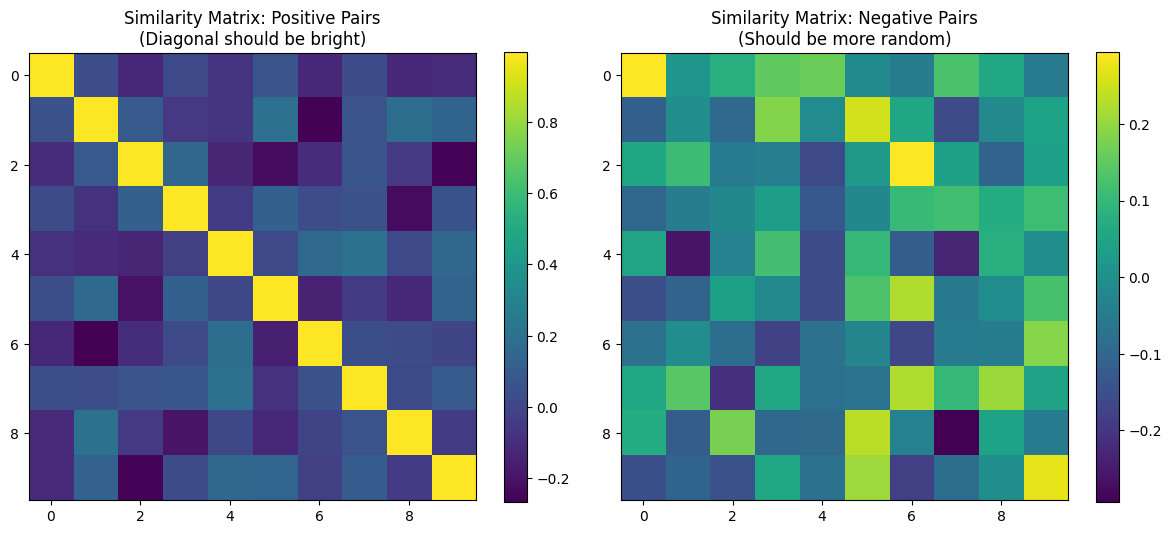

In [5]:
# Demonstrate how contrastive loss works
def demo_contrastive_loss():
    # Create toy embeddings for demonstration
    batch_size = 10
    embedding_dim = 64
    
    # Same nodes, different views
    z1 = torch.randn(batch_size, embedding_dim)
    z2 = z1 + 0.1 * torch.randn(batch_size, embedding_dim)  # Similar to z1 (positive pairs)
    
    # Different nodes (negative pairs)
    z3 = torch.randn(batch_size, embedding_dim)
    
    # Calculate losses
    model = ContrastiveGCN(in_channels=data.x.shape[1], hidden_channels=64, proj_dim=embedding_dim)
    pos_loss = model.contrastive_loss(z1, z2)
    neg_loss = model.contrastive_loss(z1, z3)
    
    print(f"Contrastive loss between similar embeddings: {pos_loss.item():.4f}")
    print(f"Contrastive loss between different embeddings: {neg_loss.item():.4f}")
    print(f"Difference (should be positive): {neg_loss.item() - pos_loss.item():.4f}")
    
    # Visualize similarity matrices
    z1_norm = torch.nn.functional.normalize(z1, dim=1)
    z2_norm = torch.nn.functional.normalize(z2, dim=1)
    z3_norm = torch.nn.functional.normalize(z3, dim=1)
    
    sim_pos = torch.mm(z1_norm, z2_norm.t())
    sim_neg = torch.mm(z1_norm, z3_norm.t())
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(sim_pos.detach(), cmap='viridis')
    plt.colorbar()
    plt.title("Similarity Matrix: Positive Pairs\n(Diagonal should be bright)")
    
    plt.subplot(1, 2, 2)
    plt.imshow(sim_neg.detach(), cmap='viridis')
    plt.colorbar()
    plt.title("Similarity Matrix: Negative Pairs\n(Should be more random)")
    
    plt.tight_layout()
    plt.show()

# Demo the contrastive loss
demo_contrastive_loss()

## 5. Training with Contrastive Learning

Now let's train our model with the contrastive learning objective. We'll train for a limited number of epochs here, but for the full implementation you can run the `main_contrastive.py` script.

In [20]:
# Hot-reload utilities to pick up the latest function signatures
import importlib
import contrastive_utils as cu
cu = importlib.reload(cu)
from contrastive_utils import (
    train_contrastive_model,
    evaluate_contrastive_model,
    create_graph_views,
)
print("Reloaded contrastive_utils; functions re-imported.")

Reloaded contrastive_utils; functions re-imported.


In [22]:
# Reload GCN modules and recreate the model to pick up updated layer signatures
import importlib
import gcn_layer as gl
import contrastive_gcn as cg

_ = importlib.reload(gl)
cg = importlib.reload(cg)
from contrastive_gcn import ContrastiveGCN

# Recreate model so its conv layers use the reloaded HigherOrderGCNLayer
contrastive_model = ContrastiveGCN(
    in_channels=data.x.shape[1],
    hidden_channels=128,
    proj_dim=64,
    tau=0.5,
)
print("Rebuilt contrastive_model with reloaded layers.")

Rebuilt contrastive_model with reloaded layers.


Training contrastive model (demonstration with 10 epochs)...
Epoch 000 | Total: 18183.0371 | Coord: 18182.3145 | Contrast: 7.2225 | MSE: 18166.83 | MeanDist: 181.24 μm
Epoch 000 | Total: 18183.0371 | Coord: 18182.3145 | Contrast: 7.2225 | MSE: 18166.83 | MeanDist: 181.24 μm
Epoch 001 | Total: 18172.9941 | Coord: 18172.2793 | Contrast: 7.1515 | MSE: 18155.25 | MeanDist: 181.18 μm
Epoch 001 | Total: 18172.9941 | Coord: 18172.2793 | Contrast: 7.1515 | MSE: 18155.25 | MeanDist: 181.18 μm
Epoch 002 | Total: 18163.3438 | Coord: 18162.6328 | Contrast: 7.1024 | MSE: 18142.32 | MeanDist: 181.11 μm
Epoch 002 | Total: 18163.3438 | Coord: 18162.6328 | Contrast: 7.1024 | MSE: 18142.32 | MeanDist: 181.11 μm
Epoch 003 | Total: 18149.9414 | Coord: 18149.2344 | Contrast: 7.0623 | MSE: 18127.93 | MeanDist: 181.03 μm
Epoch 003 | Total: 18149.9414 | Coord: 18149.2344 | Contrast: 7.0623 | MSE: 18127.93 | MeanDist: 181.03 μm
Epoch 004 | Total: 18137.5840 | Coord: 18136.8809 | Contrast: 7.0354 | MSE: 18112.2

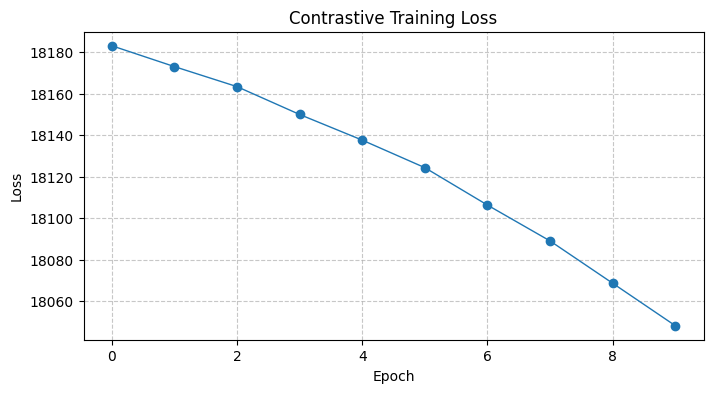

In [26]:
# Setup optimizer and loss function
optimizer = torch.optim.Adam(contrastive_model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = torch.nn.MSELoss()

# Compute adj_powers for the model (example: up to 3rd power)
def compute_adj_powers(G, max_power=3):
    import scipy.sparse as sp
    A = nx.to_scipy_sparse_array(G, format='csr')
    adj_powers = [torch.tensor((A ** k).toarray(), dtype=torch.float32) for k in range(1, max_power + 1)]
    return adj_powers

# Note: We don't need adj_powers for the current implementation

# Train for just 10 epochs for demonstration
print("Training contrastive model (demonstration with 10 epochs)...")

import time
start = time.time()
try:
    contrastive_model, train_losses = train_contrastive_model(
        contrastive_model,
        data,
        optimizer,
        criterion,
        num_epochs=10,
        lambda_contrast=0.1,
        edge_dropout_prob=0.1,      # milder augmentation for stability
        feature_mask_prob=0.1,      # milder feature masking
        log_every=1,                # print every epoch for visibility
    )
    print(f"Training finished in {time.time() - start:.1f}s")
except Exception as e:
    import traceback
    print("Training failed with error:\n", e)
    traceback.print_exc()
    raise

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses, marker='o', linewidth=1)
plt.title("Contrastive Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 6. Evaluate Contrastive Learning Results

Let's evaluate our model's performance on the coordinate prediction task.

COORDINATE PREDICTION RESULTS:
Mean Squared Error: 18010.1875
Mean Absolute Error: 122.3955
Mean Distance Error: 180.38 μm
Median Distance Error: 177.50 μm
X-coordinate correlation: 0.1336
Y-coordinate correlation: 0.1442


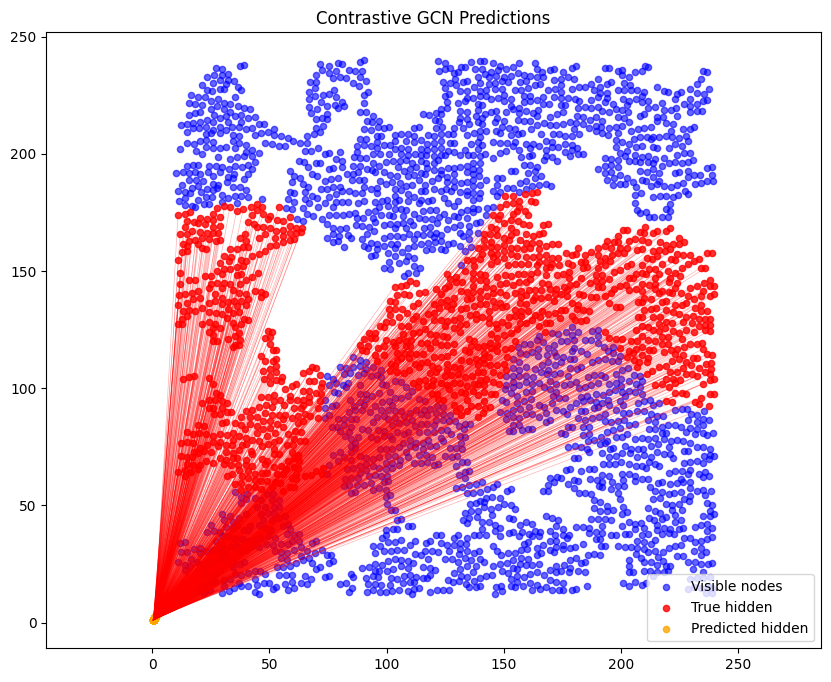

In [27]:
# Evaluate the contrastive model
results = evaluate_contrastive_model(contrastive_model, data)

# Print results
print("COORDINATE PREDICTION RESULTS:")
print(f"Mean Squared Error: {results['mse']:.4f}")
print(f"Mean Absolute Error: {results['mae']:.4f}")
print(f"Mean Distance Error: {results['mean_distance_error']:.2f} μm")
print(f"Median Distance Error: {results['median_distance_error']:.2f} μm")
print(f"X-coordinate correlation: {results['correlation_x']:.4f}")
print(f"Y-coordinate correlation: {results['correlation_y']:.4f}")

# Visualize predictions
def visualize_predictions(data, model):
    model.eval()
    with torch.no_grad():
        pred_coords = model(data)
    
    # Get coordinates and predictions
    true_coords = data.target_coords.numpy()
    pred_coords_np = pred_coords.numpy()
    
    visible_mask = data.visible_mask.numpy()
    hidden_mask = data.hidden_mask.numpy()
    
    plt.figure(figsize=(10, 8))
    
    # Plot visible nodes
    plt.scatter(true_coords[visible_mask, 0], true_coords[visible_mask, 1], 
               c='blue', alpha=0.6, s=20, label='Visible nodes')
    
    # Plot true hidden nodes
    plt.scatter(true_coords[hidden_mask, 0], true_coords[hidden_mask, 1], 
               c='red', alpha=0.8, s=20, label='True hidden')
    
    # Plot predicted hidden nodes
    plt.scatter(pred_coords_np[hidden_mask, 0], pred_coords_np[hidden_mask, 1], 
               c='orange', alpha=0.8, s=20, label='Predicted hidden')
    
    # Draw error lines
    for i in np.where(hidden_mask)[0]:
        plt.plot([true_coords[i, 0], pred_coords_np[i, 0]], 
                [true_coords[i, 1], pred_coords_np[i, 1]], 
                'r-', alpha=0.3, linewidth=0.5)
    
    plt.title('Contrastive GCN Predictions')
    plt.legend()
    plt.axis('equal')
    plt.show()

# Visualize predictions
visualize_predictions(data, contrastive_model)

## 7. Next Steps and Further Exploration

With this notebook, you've seen how contrastive learning can be applied to your nuclei coordinate prediction task. For a full training run and comparison with the standard GCN approach, run the `main_contrastive.py` script.

Some directions for further exploration:

1. **Augmentation strategies**: Experiment with different graph augmentations like subgraph sampling, edge perturbation, and feature normalization.

2. **Projection head design**: Try different architectures for the projection head used in contrastive learning.

3. **Contrastive loss variants**: Implement other contrastive objectives like BYOL, MoCo, or SimCLR.

4. **Nuclei clustering**: Use the learned embeddings to cluster nuclei and identify regions with similar topological properties.

5. **Transfer learning**: Apply the pre-trained model to other related tasks or datasets.

Analyzing learned embeddings...


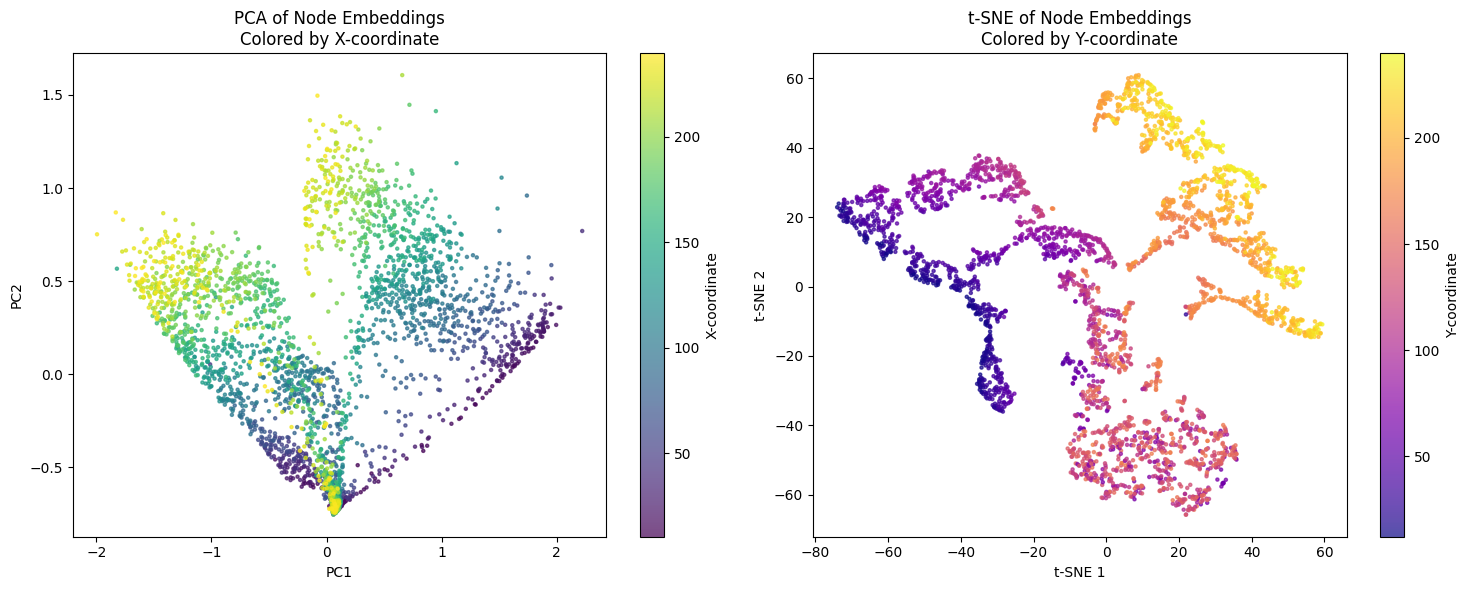


To get better results, run the full training in main_contrastive.py
python main_contrastive.py


In [28]:
# Example of analyzing learned embeddings
def analyze_embeddings(model, data):
    model.eval()
    with torch.no_grad():
        _, embeddings = model(data, return_embeddings=True)
    
    # Convert to numpy for analysis
    embeddings_np = embeddings.numpy()
    
    # Perform dimensionality reduction for visualization
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    
    # PCA
    pca = PCA(n_components=2)
    embeddings_pca = pca.fit_transform(embeddings_np)
    
    # t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_tsne = tsne.fit_transform(embeddings_np)
    
    # Visualize embeddings colored by spatial position
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # For color, use original spatial positions
    coords = data.target_coords.numpy()
    
    # PCA plot
    scatter1 = ax1.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], 
                          c=coords[:, 0], cmap='viridis', alpha=0.7, s=5)
    ax1.set_title('PCA of Node Embeddings\nColored by X-coordinate')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    plt.colorbar(scatter1, ax=ax1, label='X-coordinate')
    
    # t-SNE plot
    scatter2 = ax2.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], 
                          c=coords[:, 1], cmap='plasma', alpha=0.7, s=5)
    ax2.set_title('t-SNE of Node Embeddings\nColored by Y-coordinate')
    ax2.set_xlabel('t-SNE 1')
    ax2.set_ylabel('t-SNE 2')
    plt.colorbar(scatter2, ax=ax2, label='Y-coordinate')
    
    plt.tight_layout()
    plt.show()

# Analyze embeddings (note: with only 10 epochs of training, these won't be very informative yet)
print("Analyzing learned embeddings...")
analyze_embeddings(contrastive_model, data)

print("\nTo get better results, run the full training in main_contrastive.py")
print("python main_contrastive.py")